In [277]:
import time
import math

import numpy as np
import pandas as pd
from itertools import product
from Database.services.database import Database
from sqlalchemy import inspect
from services.data_retreival import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.strategies import *
from services.optimization_layers import *
from services.optimization import *
from services.binary_optimization import *
from services.environment_functions import *
from services.big_m_strategies import *
from services.experiments import *
from services.plotting_functions import *

Database.initialize("sqlite:///Database//financial_db.sqlite") #for courses replace this with a flat file
inspector = inspect(Database.engine)
print(inspector.get_table_names())

universe = 'SP'
if universe == 'ETF':
    imputation_method = 'Univariate' # 'Multivariate for SP'
    ticker_str = 'SPY'
else:
    imputation_method = 'Multivariate' # 'Multivariate for SP'
    ticker_str = 'AAPL' 
# exponential params

adjClose = pd.read_csv("flat_files/MonthlyAssetPrices"+ universe + ".csv", index_col=0, header = 1).iloc[1:,:]

daily_adjClose =  pd.read_csv("flat_files/DailyAssetPrices"+universe + ".csv", index_col=0, header = 1).iloc[1:,:]

TechnicalAnalysis = pd.read_csv("flat_files/TechnicalAnalysis" + universe + ".csv", index_col=[0,1])

if universe ==  'SP':
    FinancialRatios = pd.read_csv("flat_files/" + imputation_method + "WRDS.csv", index_col=[0,1])
    TechnicalAnalysis.index.names = FinancialRatios.index.names
    ContextualInfo = TechnicalAnalysis.merge(FinancialRatios, how = 'left', left_index=True, right_index=True)

else:
    TechnicalAnalysis.index.names = ['date', 'ticker']
    ContextualInfo = TechnicalAnalysis


['asset_id', 'currency_id', 'equities_series', 'equity_index_id', 'exchange_id', 'factor_id', 'factors', 'frequency_id', 'fundamentals', 'metric_id', 'source_id', 'ticker_id', 'ticker_index_membership', 'tiingo_tickers']


In [278]:
adjClose.index = pd.to_datetime(adjClose.index, format='%Y-%m-%d').tz_localize(None)
daily_adjClose.index = pd.to_datetime(daily_adjClose.index, format='%Y-%m-%d').tz_localize(None)
ContextualInfo.index = ContextualInfo.index.set_levels([pd.to_datetime(ContextualInfo.index.levels[0]).tz_localize(None), ContextualInfo.index.levels[1]])

In [279]:
print("The earliest possible start date")
max(daily_adjClose.index.unique()[0], ContextualInfo.index.get_level_values('date').unique()[0], adjClose.index.unique()[0])

The earliest possible start date


Timestamp('1996-11-30 00:00:00')

In [280]:
print("The latest possible start date")
min(daily_adjClose.index.unique()[-1], ContextualInfo.index.get_level_values('date').unique()[-1], adjClose.index.unique()[-1])

The latest possible start date


Timestamp('2023-04-21 00:00:00')

In [281]:
if universe == 'SP':
    start_date = pd.to_datetime('1996-11-30', format = '%Y-%m-%d')
    
    end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')
else:
    start_date = pd.to_datetime('2006-05-31', format = '%Y-%m-%d')
    
    end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

factors = ('Mkt-RF', 'RF')

factorRet = get_monthly_factors(factors, start_date, end_date, Database)

factorRet = factorRet.droplevel(0, axis = 1)
factorRet.columns = [col.strip() for col in factorRet.columns]

In [282]:
adjClose = adjClose[start_date:end_date]
daily_adjClose = daily_adjClose[start_date:end_date]
idx = pd.IndexSlice
ContextualInfo = ContextualInfo.loc[idx[start_date:end_date, :], :]

In [283]:
# divide the factor returns by 100
factorRet = factorRet/100

#rf and factor returns
#drop the first observation to align the dataset with the returns data that will
#result
factorRet = factorRet.iloc[1:, :]

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

In [284]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [285]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values) # risk adjusted returns
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [286]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# Experimental Analysis

In [287]:
# Some strategies (uncomment this or the next cell to pick a strategy to test)
# Strategy = general_strategy(sample_estimator, MVO, NumObs=48)  #the general strategy object takes an estimator function and an optimizer function
# the only constraint is that the estimators outputs are the optimizers inputs
# investor preferences (static throughout the backtest

initialVal = 100000
estimator_str = 'exponential_weighted_estimator_shrinkage'
premium_str = '0.25'
q = 20

In [288]:
CardMVO_path = "Experiments//"+universe+"//"+"CardMVO"
CardMVO_experiments = pd.read_pickle(CardMVO_path+"//data_dictionary.pkl")
CardMVO_experiments.run.unique() # select run

array(['SunJan212024'], dtype=object)

In [289]:
CardMVO_experiments.groupby(['cardinality_ratio', 'turnover_limit']).uid.count() 

cardinality_ratio  turnover_limit
0.02               0.75              4
                   1                 4
                   1.25              4
0.03               0.75              4
                   1                 4
                   1.25              4
0.05               0.75              4
                   1                 4
                   1.25              4
0.07               0.75              4
                   1                 4
                   1.25              4
0.09               0.75              4
                   1                 4
                   1.25              4
0.1                0.75              4
                   1                 4
                   1.25              4
0.2                0.75              4
                   1                 4
                   1.25              4
0.4                0.75              4
                   1                 4
                   1.25              4
0.6                0.75       

In [290]:
CardMVO_experiments[CardMVO_experiments.cardinality_ratio == '0.09']

,uid,estimator,optimizer,universe,imputation_method,ticker_str,hyperparam_search,NoPeriods,run,C,...,premium,q,q_alpha,separable,target_return_strategy,target_return_strategy_args,ticker_index,tightening_iter_lim,turnover_constraints,turnover_limit
ec2361ecdd88971e0706a98ffa01bc8b58a64d45,ec2361ecdd88971e0706a98ffa01bc8b58a64d45,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
e45a047e373dd9364440ad0b05a413634e03bdb7,e45a047e373dd9364440ad0b05a413634e03bdb7,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.5,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
1cc3c01f6f8986d9ef26888ee3435a180f52a0ac,1cc3c01f6f8986d9ef26888ee3435a180f52a0ac,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
cfff72524321f237e28b9b7e717057cbd874175e,cfff72524321f237e28b9b7e717057cbd874175e,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1.5,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
d1247b448be27ba56967738dd6dbdf1d9a34661c,d1247b448be27ba56967738dd6dbdf1d9a34661c,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,1
d8829acef536e7fc8defd21d36776453b7826751,d8829acef536e7fc8defd21d36776453b7826751,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.5,20,0.6838,False,premium_target,['premium'],0,1,True,1
ea9d007edf9ff753a6ecd8e9eb6fd9a91772362b,ea9d007edf9ff753a6ecd8e9eb6fd9a91772362b,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,1
366ae5fdbc7b6eb1b7ebccf601614c54820822ec,366ae5fdbc7b6eb1b7ebccf601614c54820822ec,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1.5,20,0.6838,False,premium_target,['premium'],0,1,True,1
f60b27e243991add19da1115510c283179393298,f60b27e243991add19da1115510c283179393298,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,1.25
884012f4aaa4c745f5c1cc6e7b4a5aea2c185613,884012f4aaa4c745f5c1cc6e7b4a5aea2c185613,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.5,20,0.6838,False,premium_target,['premium'],0,1,True,1.25


In [291]:
# Filtering step for CardMVO experiments
CardMVO_experiments = CardMVO_experiments[CardMVO_experiments.estimator == estimator_str]
CardMVO_experiments = CardMVO_experiments[CardMVO_experiments.premium == premium_str]
CardMVO_experiments = CardMVO_experiments[CardMVO_experiments.q == str(q)]
assert (CardMVO_experiments.groupby(['cardinality_ratio', 'turnover_limit']).uid.count() == 1).all()

In [292]:
unique_card_turnover_df = CardMVO_experiments.groupby(['cardinality_ratio', 'turnover_limit']).uid.first() # unique experiments
unique_card_turnover_df

cardinality_ratio  turnover_limit
0.02               0.75              36e421fe68a77ac5473f8c45e8a53c0ad1748621
                   1                 891085c8526f09e9f96fefba6e577b29f3ae1a91
                   1.25              9d4d63a078fd0e88090fe1ef2505ea98c27dfdd2
0.03               0.75              d336e4ed68f2433333ee5dd8bedb34665ae859ee
                   1                 dbedfafa1e8e0b7373cc6cc47f43308a82f31e34
                   1.25              bd26466efc542d3d6442360e79db96e4789ad77b
0.05               0.75              2bb599a1bbe168a4e4ec561624845d7fbd43efc4
                   1                 83a1bf893ebc470660186e82ea58584a125a3aa7
                   1.25              b28162fcbedbbea32b3294870f67319f732ea8c9
0.07               0.75              92628408ba4d1cb5dc5adaa95e50567114277743
                   1                 4c98d6f84e7611fe2b18359771169eb9cafabff3
                   1.25              b0fbbeccdf68643cc53d4ef854698bd25ba48b97
0.09               0.75       

In [293]:
CardMVO_experiments

,uid,estimator,optimizer,universe,imputation_method,ticker_str,hyperparam_search,NoPeriods,run,C,...,premium,q,q_alpha,separable,target_return_strategy,target_return_strategy_args,ticker_index,tightening_iter_lim,turnover_constraints,turnover_limit
36e421fe68a77ac5473f8c45e8a53c0ad1748621,36e421fe68a77ac5473f8c45e8a53c0ad1748621,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
891085c8526f09e9f96fefba6e577b29f3ae1a91,891085c8526f09e9f96fefba6e577b29f3ae1a91,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,1
9d4d63a078fd0e88090fe1ef2505ea98c27dfdd2,9d4d63a078fd0e88090fe1ef2505ea98c27dfdd2,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,1.25
d336e4ed68f2433333ee5dd8bedb34665ae859ee,d336e4ed68f2433333ee5dd8bedb34665ae859ee,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
dbedfafa1e8e0b7373cc6cc47f43308a82f31e34,dbedfafa1e8e0b7373cc6cc47f43308a82f31e34,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,1
bd26466efc542d3d6442360e79db96e4789ad77b,bd26466efc542d3d6442360e79db96e4789ad77b,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,1.25
2bb599a1bbe168a4e4ec561624845d7fbd43efc4,2bb599a1bbe168a4e4ec561624845d7fbd43efc4,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
83a1bf893ebc470660186e82ea58584a125a3aa7,83a1bf893ebc470660186e82ea58584a125a3aa7,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,1
b28162fcbedbbea32b3294870f67319f732ea8c9,b28162fcbedbbea32b3294870f67319f732ea8c9,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,1.25
92628408ba4d1cb5dc5adaa95e50567114277743,92628408ba4d1cb5dc5adaa95e50567114277743,exponential_weighted_estimator_shrinkage,CardMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,0.75


In [294]:
# read in SVMMVO experiments and see what is going on
SVMMVO_path_q = "Experiments//"+universe+"//"+"ClassWgtSVMMVO"+"//"+str(q)
SVMMVO_experiments_q = pd.read_pickle(SVMMVO_path_q+"//data_dictionary.pkl")
print("q =", q, " runs available: ", SVMMVO_experiments_q.run.unique())

q = 20  runs available:  ['SunJan212024']


In [295]:
SVMMVO_experiments_q

,uid,estimator,optimizer,universe,imputation_method,ticker_str,hyperparam_search,NoPeriods,run,C,...,premium,q,q_alpha,separable,target_return_strategy,target_return_strategy_args,ticker_index,tightening_iter_lim,turnover_constraints,turnover_limit
9cda95b998d52dd0922ee4fd49479e73b30979e2,9cda95b998d52dd0922ee4fd49479e73b30979e2,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
7f21a0a13c5c8fabef30d0b949cb20220dce0d7b,7f21a0a13c5c8fabef30d0b949cb20220dce0d7b,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.5,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
604213c84810168fa569b03dcbce9cf20508cc7f,604213c84810168fa569b03dcbce9cf20508cc7f,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
95e9c2af9fc535e09ca1471e8c16afaa97a5586c,95e9c2af9fc535e09ca1471e8c16afaa97a5586c,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1.5,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
c2752a4d95555f704c18c0f692c1ed302d2e951e,c2752a4d95555f704c18c0f692c1ed302d2e951e,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c41096d505fa5eabeba2cb7ce7594a20e4061ea8,c41096d505fa5eabeba2cb7ce7594a20e4061ea8,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1.5,20,0.6838,False,premium_target,['premium'],0,1,True,1.25
7e225cf2ca4e9a988b23e56e1588ffb85a5fb8a0,7e225cf2ca4e9a988b23e56e1588ffb85a5fb8a0,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.25,20,0.6838,False,premium_target,['premium'],0,1,True,1.25
8658a51bd52db7455f98119838a74a6619f19b75,8658a51bd52db7455f98119838a74a6619f19b75,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,0.5,20,0.6838,False,premium_target,['premium'],0,1,True,1.25
c1dfd75b86418e73232c42bf33b61a1329e21ec4,c1dfd75b86418e73232c42bf33b61a1329e21ec4,exponential_weighted_estimator_shrinkage,ClassWgtSVMMVO,SP,Multivariate,AAPL,False,48,SunJan212024,0.1,...,1,20,0.6838,False,premium_target,['premium'],0,1,True,1.25


In [296]:
SVMMVO_experiments_q.drop_duplicates().groupby(['kappa', 'cardinality_ratio']).uid.count()

kappa   cardinality_ratio
0.0125  0.02                 12
        0.03                 12
        0.05                 12
        0.07                 12
        0.09                 12
        0.1                  12
        0.2                  12
        0.4                  12
        0.6                  12
        0.8                  12
0.025   0.02                 12
        0.03                 12
        0.05                 12
        0.07                 12
        0.09                 12
        0.1                  12
        0.2                  12
        0.4                  12
        0.6                  12
        0.8                  12
0.05    0.02                 12
        0.03                 12
        0.05                 12
        0.07                 12
        0.09                 12
        0.1                  12
        0.2                  12
        0.4                  12
        0.6                  12
        0.8                  12
0.1     0.02  

In [297]:
SVMMVO_experiments_q.drop_duplicates().groupby(['cardinality_ratio', 'turnover_limit', 'kappa']).uid.count()

cardinality_ratio  turnover_limit  kappa 
0.02               0.75            0.0125    4
                                   0.025     4
                                   0.05      4
                                   0.1       4
                                   0.2       4
                                            ..
0.8                1.25            0.0125    4
                                   0.025     4
                                   0.05      4
                                   0.1       4
                                   0.2       4
Name: uid, Length: 150, dtype: int64

In [298]:
SVMMVO_experiments_q.estimator.unique()

array(['exponential_weighted_estimator_shrinkage'], dtype=object)

In [299]:
cardinality_ratios = np.sort(SVMMVO_experiments_q.cardinality_ratio.unique())
cardinality_ratios

array(['0.02', '0.03', '0.05', '0.07', '0.09', '0.1', '0.2', '0.4', '0.6',
       '0.8'], dtype=object)

In [300]:
kappas = np.sort(SVMMVO_experiments_q.kappa.unique())
kappas

array(['0.0125', '0.025', '0.05', '0.1', '0.2'], dtype=object)

In [301]:
# filtering step
SVMMVO_experiments_q =SVMMVO_experiments_q[SVMMVO_experiments_q.estimator == estimator_str]
SVMMVO_experiments_q =SVMMVO_experiments_q[SVMMVO_experiments_q.premium == premium_str]

assert (SVMMVO_experiments_q.groupby(['cardinality_ratio', 'turnover_limit', 'kappa']).uid.count() == 1).all()

In [302]:
# prepare the results dictionary
CardMVO_results = {}
MVO_results = {}

for i in unique_card_turnover_df.index:
    CardMVO_results[i] = import_experimental_results(CardMVO_path, unique_card_turnover_df[i])
    if float(i[0]) > 0.99: # no restrictions on cardinality
        MVO_results[i[1]] = import_experimental_results(CardMVO_path, unique_card_turnover_df[i]) #MVO dict is a function of turnover

In [303]:
# prepare the results dictionary for
unique_svmmvo_turnover_df = SVMMVO_experiments_q.groupby(['cardinality_ratio', 'turnover_limit', 'kappa']).uid.first()
SVMMVO_results_q = {}

SVMMVO_path_q = "Experiments//"+universe+"//"+"ClassWgtSVMMVO"+"//"+str(q)
for i in unique_svmmvo_turnover_df.index:
    SVMMVO_results_q[i] = import_experimental_results(SVMMVO_path_q, unique_svmmvo_turnover_df[i])

In [304]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 0.1


def plot_results_relative_ticker(CardMVO_results, MVO_results, SVMMVO_results_q, turnovers, cardinalities, q, kappas
                                 , adjClose, initialVal=100000, ticker_str='SPY', figsize=(8.5, 9), turnoff_q = True):

    if turnoff_q:
        q = ''
    lw = 0.75
    win_count = 0
    loss_count = 0

    fig, axs = plt.subplots(len(cardinalities), len(turnovers),
                            sharex=True, figsize=figsize)

    if len(cardinalities) == 1:
        axs = np.expand_dims(axs, axis=0)
    if len(turnovers) == 1:
        axs = np.expand_dims(axs, axis=1)

    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                      '#a65628', '#f781bf', '#984ea3',
                      '#999999', '#e41a1c', '#dede00']
    win_rates = {}
    loss_rates = {}
    for kappa in kappas:
        win_rates[kappa] = 0
        loss_rates[kappa] = 0
    # load in the appropriate files
    for i in range(len(cardinalities)):

        
        for j in range(len(turnovers)):
            max_y = 5
            min_y = -5
            turnover_lim = turnovers[j]
            card = cardinalities[i]
            card_mvo_wealth, elapsed_time, x, turnover = CardMVO_results[(str(card), str(turnover_lim))]
            if ticker_str is not None:
                value_target_index = adjClose.loc[card_mvo_wealth.index, ticker_str]
                time0 = value_target_index.index[0] - pd.offsets.MonthEnd(1)
                spy_time0 = adjClose.loc[time0, ticker_str]
                value_target_index = initialVal * value_target_index / spy_time0

            card_mvo_wealth.columns = ['Card-MVO']

            # mvo_wealth, elapsed_time, x, turnover = MVO_results[str(turnover_lim)]
            # mvo_wealth.columns = ['MVO']
            #
            # card_mvo_rel_wealth = pd.Series(card_mvo_wealth.values.flatten() / mvo_wealth.values.flatten(),
            #                                 index=card_mvo_wealth.index)
            # mvo_wealth_rel_wealth = pd.Series(mvo_wealth.values.flatten() / value_target_index.values.flatten(),
            #                                   index=mvo_wealth.index)
            index_rel_wealth = pd.Series(value_target_index.values.flatten() / card_mvo_wealth.values.flatten(),
                                            index=card_mvo_wealth.index)

            k = 0
            for kappa in kappas:
                svmmvo_wealth, elapsed_time, x, turnover = SVMMVO_results_q[(str(card), str(turnover_lim), str(kappa))]
                svmmvo_wealth.columns = ['SVM-MVO-'+str(q)]
                svmmvo_rel_wealth = 100*(pd.Series(svmmvo_wealth.values.flatten() / card_mvo_wealth.values.flatten(),
                                            index=svmmvo_wealth.index) - 1)

                if k%2 == 0:
                    style =  '-'# '(0, (3, 1, 1, 1))
                else:
                    style = '-'
                svmmvo_rel_wealth.plot(fontsize=5, ax=axs[i, j], linewidth=lw, linestyle=style,
                                       legend=False,
                                       label='SVM-MVO -'+str(q)+r' $\kappa =$' + str(kappa), rot=45, color = CB_color_cycle[k])
                k+=1
                if svmmvo_rel_wealth.iloc[-1] > 5:
                    win_count += 1
                    win_rates[kappa] += 1
                elif svmmvo_rel_wealth.iloc[-1] < -5:
                    loss_count += 1
                    loss_rates[kappa] += 1
                max_ = svmmvo_rel_wealth.max() #card_mvo_rel_wealth.max()  # [0]
                min_ = svmmvo_rel_wealth.min()
                # print(max_)
                if max_ > max_y:
                    max_y = max_
                if min_ < min_y:
                    min_y = min_
            # if ticker_str is not None:
            # value_target_index.plot(fontsize = 8, ax=axs[i, j], linewidth = lw, legend = False)
            #print(svmmvo_rel_wealth.max())
            card_string = r"$K = \lfloor "+str(card)+ r"N \rfloor$"
            turnover_string = "$C_0 = "+str(turnover_lim)+"$"

            axs[i, j].set_title(card_string + ", " + turnover_string, fontsize = 5, pad=0.75)
            # print(card_mvo_wealth.max()[0])
            axs[i, j].tick_params(axis='x', labelsize=4, width = 0.1)
            axs[i, j].tick_params(which='minor',  width = 0.1)
            axs[i, j].tick_params(axis='y', labelsize=4, width = 0.1)
            
            axs[i, j].yaxis.set_tick_params(which='minor', bottom=False)
            
            min_y = math.floor(min_y/2.5)*2.5
            max_y = math.ceil(max_y/2.5)*2.5
          
            spacing = (max_y - min_y)/7 #number of lines
            spacing = math.ceil(spacing/2.5)*2.5
            
            y_ticks = ([0 - i * spacing for i in range(1+math.ceil((0 - min_y) / spacing))] 
                       + [0 + i * spacing for i in range(1+math.ceil((max_y - 0) / spacing))])
            
            axs[i, j].set_yticks(y_ticks)
            
            axs[i, j].grid(color='#A9A9A9', linestyle=':', linewidth=0.2)
            axs[i, j].set_xlabel("", fontsize = 5)

    axs[len(cardinalities) - 1, 0].legend(loc='upper center',
                                          bbox_to_anchor=(1.8, -0.7),
                                          fancybox=False,
                                          shadow=False, ncol=4,
                                          fontsize = 5)

    # min_y = math.floor(min_y*10)/10
    # spacing = (max_y - min_y)/5
    # spacing = 0.05*math.ceil(spacing/0.1)
    # axs[len(cardinalities) - 1, 0].set_yticks([min_y + i * spacing for i in range(2 + int((max_y - min_y) / spacing))])
    # #axs[len(cardinalities) - 1, 0].grid()
    # axs[len(cardinalities) - 1, 0].set_xlabel("Date", fontsize = 5)

    # fig.supylabel("Cumulative Relative Wealth %: " + r"$W_{SVMMVO} / W_{CardMVO} - 1$", x = 0.05, y = 0.5, fontsize = 6)
    fig.supylabel("Cumulative Relative Wealth %", x = 0.05, y = 0.5, fontsize = 6)

    plt.tight_layout()
    fig.subplots_adjust(wspace=0.3, hspace=0.4)
    print("Number of instances where SVMMVO won ", win_count)
    print("Number of instances where SVMMVO lost ", loss_count)
    print("Number of instances ", len(cardinalities)*len(turnovers)*len(kappas))
    print("% of instances where SVMMVO won ", win_count/(len(cardinalities)*len(turnovers)*len(kappas)))
    print("% of instances where SVMMVO lost ", loss_count/(len(cardinalities)*len(turnovers)*len(kappas)))
    return win_rates, loss_rates

In [305]:
if universe == 'ETF':
    kappas_plot = kappas[-3:]
    cardinality_ratios = [0.03, 0.05, 0.07, 0.1, 0.2, 0.4, 0.6, 0.8] #, 0.2, 0.4, 0.6, 0.8] #[0.01, 0.03, 0.05, 0.07, 0.09]#[0.1, 0.2, 0.4, 0.6] #[0.03, 0.05, 0.07, 0.09] # includes mvo
else:
    kappas_plot = kappas[:3]
    cardinality_ratios = [0.03, 0.05, 0.07, 0.1, 0.2, 0.4, 0.6, 0.8] #, 0.2, 0.4, 0.6, 0.8] #[0.01, 0.03, 0.05, 0.07, 0.09]#[0.1, 0.2, 0.4, 0.6] #[0.03, 0.05, 0.07, 0.09] # includes mvo
    #cardinality_ratios = [0.2, 0.4, 0.6, 0.8]

C:\Users\david\AppData\Local\Temp\ipykernel_32008\1385223255.py:130: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


Number of instances where SVMMVO won  15
Number of instances where SVMMVO lost  10
Number of instances  72
% of instances where SVMMVO won  0.20833333333333334
% of instances where SVMMVO lost  0.1388888888888889
images/SVMMVO_SP_20prem_0.25


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


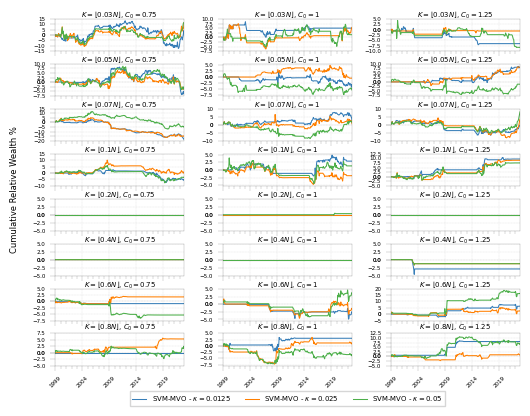

In [306]:
turnover_limits = [0.75, 1, 1.25]

win_rates, loss_rates = plot_results_relative_ticker(CardMVO_results, MVO_results, SVMMVO_results_q,
                             turnover_limits, cardinality_ratios, q, kappas_plot,
                             adjClose, initialVal=100000, ticker_str=ticker_str, figsize=(6, 4.5))
experiment_str = "SVMMVO_"+universe + "_" + str(q) + "prem_"+ premium_str
plot_str = "images/"+experiment_str
print(plot_str)
plt.savefig(plot_str + ".eps", bbox_inches='tight')
plt.savefig(plot_str + ".svg", bbox_inches='tight')

In [335]:
win_rates

{'0.0125': 5, '0.025': 5, '0.05': 5}

In [225]:
loss_rates

{'0.0125': 5, '0.025': 1, '0.05': 4}

In [226]:
def calculate_return_stats(portfValue, riskFree):
    portfRets = portfValue.pct_change(1).iloc[1:, :]
    # Calculate the portfolio excess returns
    portfExRets = portfRets.subtract(
        riskFree[(riskFree.index >= portfRets.index[0]) & (riskFree.index <= portfRets.index[-1])], axis=0)

    # Calculate the portfolio Sharpe ratio
    Ret = 12 * ((portfExRets + 1).apply(gmean, axis=0) - 1)
    Vol = (12 ** 0.5) * (portfExRets.std())
    SR = (12 ** 0.5) * (((portfExRets + 1).apply(gmean, axis=0) - 1) / portfExRets.std())
    Sortino = (12**0.5)*(((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.loc[portfExRets.values < 0].std())
    # Calculate the average turnover rate

    return Ret.iloc[0], Vol.iloc[0], SR.iloc[0] , Sortino.iloc[0]


In [227]:
def make_stats_table(CardMVO_results, SVMMVO_results_q,
                             turnovers, cardinalities, q, kappas_plot, riskFree):
    df_cols = []
    # load in the appropriate files

    for j in range(len(turnovers)):
        df_rows = []
        turnover_lim = turnovers[j]
        turnover_string = "$C_0 = "+str(turnover_lim)+"$"
        # mvo_wealth, elapsed_time, x, turnover = MVO_results[str(turnover_lim)]
        # mvo_wealth.columns = ['MVO']

        # mvo_ret_stats = calculate_return_stats(mvo_wealth, riskFree)
        ret_stats = []
        
        row_tuples = [(turnover_string, '', "MVO", "")]
        row_index = pd.MultiIndex.from_tuples(row_tuples)
        col_index = [ "$\mu$",  "$\sigma$", "S.R", 'Sortino.R']  # , (card_string,"Sortino.R")]
        
        # out = pd.DataFrame(ret_stats, index=row_index, columns=col_index)
        # df_rows.append(out)
        
        for i in range(len(cardinalities)):
            
            card = cardinalities[i]
            card_mvo_wealth, elapsed_time, x, turnover = CardMVO_results[(str(card), str(turnover_lim))]

            card_mvo_wealth.columns = ['Card-MVO']

           
            card_ret_stats = calculate_return_stats(card_mvo_wealth, riskFree)

            card_string = r"$K = \lfloor "+str(card)+ r"N \rfloor$"


            row_tuples = [(turnover_string, card_string, "Card MVO", "")]
            row_index = pd.MultiIndex.from_tuples(row_tuples)

            #col_index = pd.MultiIndex.from_tuples(col_tuples)
            ret_stats = [card_ret_stats]

            out = pd.DataFrame(ret_stats, index=row_index, columns=col_index)

            df_rows.append(out)
            
            for kappa in kappas_plot:
                svmmvo_wealth, elapsed_time, x, turnover = SVMMVO_results_q[(str(card), str(turnover_lim), str(kappa))]
                svmmvo_wealth.columns = ['SVMMVO-'+str(q)]
                svmmvo_ret_stats = calculate_return_stats(svmmvo_wealth, riskFree)
    
                kappa_str = r'$\kappa =$' + str(kappa)
                row_tuples = [(turnover_string, card_string, "SVMMVO "+ str(q), kappa_str )]
                row_index = pd.MultiIndex.from_tuples(row_tuples)


                ret_stats = [svmmvo_ret_stats]
    
                out = pd.DataFrame(ret_stats, index=row_index, columns=col_index)
    
                df_rows.append(out)

        column = pd.concat(df_rows)
        #print(column)
        df_cols.append(column)

    return pd.concat(df_cols, axis=0)

In [116]:
df = make_stats_table(CardMVO_results, SVMMVO_results_q,
                             turnover_limits, cardinality_ratios, q, kappas_plot, riskFree)

In [117]:
df.stack().unstack(level = 0).unstack(level = -1).to_csv("results/"+ experiment_str+ ".csv")

In [118]:
df.stack(level = 0).to_csv("results/"+ experiment_str+ ".csv")

In [324]:
# print(df.to_latex(index=False,
#                   formatters={"name": str.upper},
#                   float_format="{:.3f}".format,
# ))